In [6]:
#pip install nltk

In [7]:
#pip install spacy


In [8]:
#import libraries
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import spacy
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from scipy.stats import uniform, norm, poisson
from sklearn.model_selection import RandomizedSearchCV

[nltk_data] Downloading package punkt to C:\Users\Josiah
[nltk_data]     Lee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Josiah
[nltk_data]     Lee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
data = pd.DataFrame(pd.read_csv('../Twitter Sentiment/cleanedNspelt.csv'))

def helper(string):
    temp = []
    for word in string[1:-1].split(','):
        word = word.strip()
        word = word[1:-1]
        if word:
          temp.append(word)  
    return temp
data.filtered_tokens = data.filtered_tokens.apply(helper)

Use if machine is not very strong

In [10]:
#data = data.iloc[25000:75000]
#data.shape

In [11]:
# Split the dataset

X_train, X_test, y_train, y_test = train_test_split(data.filtered_tokens, data.labels, stratify = data.labels, test_size=0.2, random_state=42)

In [12]:
vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2), stop_words='english')
sentences = [' '.join(words) for words in X_train]

# Fit and transform the sentences
one_hot_encoded = vectorizer.fit_transform(sentences)

In [13]:
test = SelectKBest(score_func=chi2, k=1000)
X_train_new = test.fit_transform(one_hot_encoded, y_train)

In [14]:
clf1 = BernoulliNB()
clf2 = LogisticRegression(random_state = 42, penalty = 'l2', C = 1, solver = 'saga')
clf3 = RandomForestClassifier(n_estimators=100, random_state=42)

In [27]:
eclf1 = VotingClassifier(estimators=[('nb', clf1), ('lr', clf2), ('rf', clf3)], voting='soft')
eclf1.fit(X_train_new, y_train)

VotingClassifier(estimators=[('nb', BernoulliNB()),
                             ('lr',
                              LogisticRegression(C=1, random_state=42,
                                                 solver='saga')),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft')

In [18]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test.transform(X_test_new)
y_pred = eclf1.predict(X_test_new)

In [21]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.7493
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.74     10000
           1       0.73      0.78      0.76     10000

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000



In [26]:
eclf1.get_params()

{'estimators': [('nb', BernoulliNB()),
  ('lr', LogisticRegression(C=1, random_state=42, solver='saga')),
  ('rf', RandomForestClassifier(random_state=42))],
 'flatten_transform': True,
 'n_jobs': None,
 'verbose': False,
 'voting': 'hard',
 'weights': None,
 'nb': BernoulliNB(),
 'lr': LogisticRegression(C=1, random_state=42, solver='saga'),
 'rf': RandomForestClassifier(random_state=42),
 'nb__alpha': 1.0,
 'nb__binarize': 0.0,
 'nb__class_prior': None,
 'nb__fit_prior': True,
 'nb__force_alpha': 'warn',
 'lr__C': 1,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': 42,
 'lr__solver': 'saga',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features

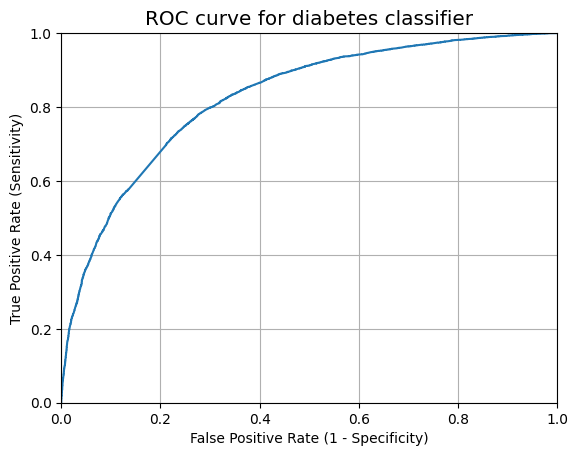

In [31]:

y_pred_prob = eclf1.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Voting lassifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [35]:
print(roc_auc_score(y_test, y_pred_prob))

0.8247455850000001


In [59]:
distributions = {'lr__penalty':['l1', 'l2'], 'rf__n_estimators':poisson(mu = 20), 'lr__C':uniform(loc = 0, scale = 1.5)}

In [60]:
rscv = RandomizedSearchCV(eclf1, distributions, random_state=42, verbose=2, n_jobs = -1)
rscv.fit(X_train_new, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.5618101782710437, lr__penalty=l1, rf__n_estimators=15; total time=  23.3s


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.5618101782710437, lr__penalty=l1, rf__n_estimators=15; total time=  23.4s


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.5618101782710437, lr__penalty=l1, rf__n_estimators=15; total time=  22.4s


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.5618101782710437, lr__penalty=l1, rf__n_estimators=15; total time=  22.6s


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.5618101782710437, lr__penalty=l1, rf__n_estimators=15; total time=  23.7s
[CV] END lr__C=0.8952752369197305, lr__penalty=l2, rf__n_estimators=15; total time=  12.5s
[CV] END lr__C=0.8952752369197305, lr__penalty=l2, rf__n_estimators=15; total time=  12.7s
[CV] END lr__C=0.8952752369197305, lr__penalty=l2, rf__n_estimators=15; total time=  12.7s
[CV] END lr__C=0.8952752369197305, lr__penalty=l2, rf__n_estimators=15; total time=  12.8s
[CV] END lr__C=0.8952752369197305, lr__penalty=l2, rf__n_estimators=15; total time=  12.4s
[CV] END lr__C=1.2992642186624028, lr__penalty=l2, rf__n_estimators=14; total time=  11.7s
[CV] END lr__C=1.2992642186624028, lr__penalty=l2, rf__n_estimators=14; total time=  11.8s
[CV] END lr__C=1.2992642186624028, lr__penalty=l2, rf__n_estimators=14; total time=  11.8s
[CV] END lr__C=1.2992642186624028, lr__penalty=l2, rf__n_estimators=14; total time=  11.8s
[CV] END lr__C=1.2992642186624028, lr__penalty=l2, rf__n_estimators=14; total time=  11.7s

c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.2727374508106509, lr__penalty=l1, rf__n_estimators=22; total time=  26.0s


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.2727374508106509, lr__penalty=l1, rf__n_estimators=22; total time=  25.8s


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.2727374508106509, lr__penalty=l1, rf__n_estimators=22; total time=  25.9s
[CV] END lr__C=0.010599457829576109, lr__penalty=l1, rf__n_estimators=17; total time=  13.9s
[CV] END lr__C=0.010599457829576109, lr__penalty=l1, rf__n_estimators=17; total time=  14.0s
[CV] END lr__C=0.010599457829576109, lr__penalty=l1, rf__n_estimators=17; total time=  14.0s
[CV] END lr__C=0.010599457829576109, lr__penalty=l1, rf__n_estimators=17; total time=  14.0s
[CV] END lr__C=0.010599457829576109, lr__penalty=l1, rf__n_estimators=17; total time=  14.0s
[CV] END lr__C=0.20924079097806275, lr__penalty=l2, rf__n_estimators=13; total time=  10.6s
[CV] END lr__C=0.20924079097806275, lr__penalty=l2, rf__n_estimators=13; total time=  10.7s
[CV] END lr__C=0.20924079097806275, lr__penalty=l2, rf__n_estimators=13; total time=  10.7s
[CV] END lr__C=0.20924079097806275, lr__penalty=l2, rf__n_estimators=13; total time=  10.7s
[CV] END lr__C=0.20924079097806275, lr__penalty=l2, rf__n_estimators=13; tot

c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.9113172778521575, lr__penalty=l1, rf__n_estimators=19; total time=  27.1s


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.9113172778521575, lr__penalty=l1, rf__n_estimators=19; total time=  27.0s


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.9113172778521575, lr__penalty=l1, rf__n_estimators=19; total time=  27.0s


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.9113172778521575, lr__penalty=l1, rf__n_estimators=19; total time=  26.9s


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.9113172778521575, lr__penalty=l1, rf__n_estimators=19; total time=  27.1s
[CV] END lr__C=1.4133026335272791, lr__penalty=l2, rf__n_estimators=24; total time=  19.8s
[CV] END lr__C=1.4133026335272791, lr__penalty=l2, rf__n_estimators=24; total time=  19.8s
[CV] END lr__C=1.4133026335272791, lr__penalty=l2, rf__n_estimators=24; total time=  20.0s
[CV] END lr__C=1.4133026335272791, lr__penalty=l2, rf__n_estimators=24; total time=  19.9s
[CV] END lr__C=1.4133026335272791, lr__penalty=l2, rf__n_estimators=24; total time=  19.8s


RandomizedSearchCV(estimator=VotingClassifier(estimators=[('nb', BernoulliNB()),
                                                          ('lr',
                                                           LogisticRegression(C=1,
                                                                              random_state=42,
                                                                              solver='saga')),
                                                          ('rf',
                                                           RandomForestClassifier(random_state=42))],
                                              voting='soft'),
                   param_distributions={'lr__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CA42D00100>,
                                        'lr__penalty': ['l1', 'l2'],
                                        'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CA42CF7820>},
                   random_state=42, verbose=2)

In [68]:
rscv.cv_results_['mean_test_score']

array([0.7544875, 0.75495  , 0.755175 , 0.75325  , 0.7535375, 0.750975 ,
       0.753825 , 0.7542375, 0.754925 , 0.754775 ])

In [61]:
y_pred = rscv.predict(X_test_new)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.75125
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.74     10000
           1       0.74      0.78      0.76     10000

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000



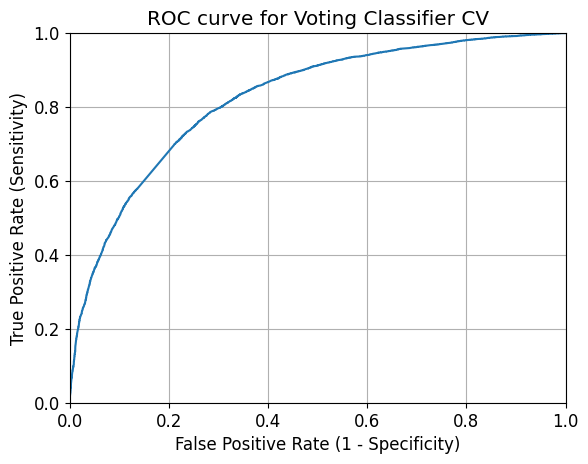

In [63]:
y_pred_prob = rscv.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Voting Classifier CV')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [69]:
print(roc_auc_score(y_test, y_pred_prob))

0.8240875049999999
